In [1]:
library(hise)
library(ggplot2)
library(stats)

library(parallel)
library(readxl)
library(tidyverse)
library(dplyr)


Warning message:
“package ‘readxl’ was built under R version 4.3.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts

In [2]:
df<-read.csv("HAI_All_Batch_for_QC.csv")

In [3]:
meta_data=read.csv("/home//workspace/private/bri_figure_all_files_test/jupyter/BRI_Figures_Final_V2/Dataset/scRNA_meta_data-2024-05-09.csv")


In [4]:
meta_data$sample.drawDate <- as.Date(meta_data$sample.drawDate)
 
meta_data <- meta_data %>%
  mutate(Flu_Year = case_when(
    sample.drawDate <= as.Date('2020-07-01') ~ '2019-2020',
    sample.drawDate > as.Date('2020-07-01') & sample.drawDate <= as.Date('2021-07-01') ~ '2020-2021',
    sample.drawDate > as.Date('2021-07-01') & sample.drawDate <= as.Date('2022-07-01') ~ '2021-2022',
    sample.drawDate > as.Date('2022-07-01') & sample.drawDate <= as.Date('2023-07-01') ~ '2022-2023',
    TRUE ~ "NA"
  ))

meta_data <- meta_data %>%
  mutate(Flu_Day = case_when(
    sample.visitName	%in% c("Flu Year 1 Day 0","Flu Year 2 Day 0","Immune Variation Day 0") ~ 'Day_0',
    sample.visitName	%in% c("Flu Year 1 Day 7","Flu Year 2 Day 7",'Immune Variation Day 7') ~ 'Day_7',
    sample.visitName	%in% c("Flu Year 1 Day 90","Flu Year 2 Day 90",'Immune Variation Day 90') ~ 'Day_90',
    sample.visitName	%in% c("Flu Year 1 Stand-Alone","Flu Year 2 Stand-Alone","Flu Year 3 Stand-Alone") ~ 'Stand-Alone',
    TRUE ~ sample.visitName
  ))




meta_data <- meta_data %>%
  mutate(Visit_Type = case_when(
    startsWith(sample.visitName, "Flu Year") ~ "FluYear",
    startsWith(sample.visitName, "Immune Variation") ~ "ImmVar",
    TRUE ~ sample.visitName  
  ))

meta_data <- meta_data %>%
  mutate(Year_N = case_when(
    startsWith(sample.visitName, "Flu Year 1") ~ "Year 1",
    startsWith(sample.visitName, "Flu Year 2") ~ "Year 2",
      startsWith(sample.visitName, "Flu Year 2") ~ "Year 3",
    startsWith(sample.visitName, "Immune Variation") ~ "ImmVar",
    TRUE ~ sample.visitName  
  ))

meta_data <- meta_data %>% 
  dplyr::group_by(Year_N, subject.subjectGuid, Visit_Type) %>% 
  dplyr::arrange(Flu_Day) %>% 
  dplyr::mutate(Flu_Year = first(Flu_Year))

meta_data$Visit_Flu_Year<-paste0(meta_data$Visit_Type,"_",meta_data$Flu_Year,"_",meta_data$Flu_Day)

In [5]:
df<-df%>% filter(Sample.Kit.ID	 %in% meta_data$sample.sampleKitGuid)

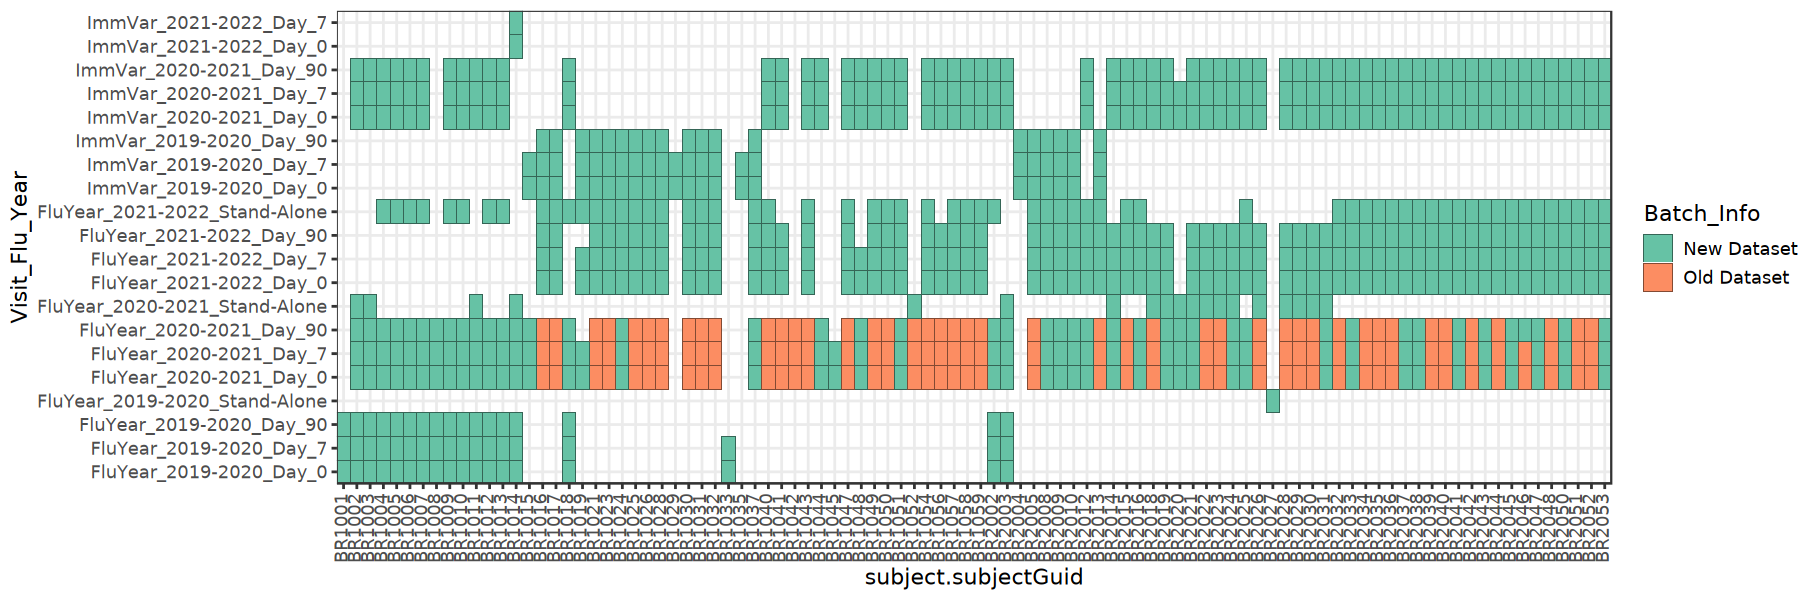

In [6]:
options(repr.plot.width = 15, repr.plot.height =5)
meta_data_vis<-left_join(meta_data,unique(df[c("Sample.Kit.ID","Batch")]),by=c("sample.sampleKitGuid"="Sample.Kit.ID"))

meta_data_vis$Batch<-gsub("MSD_HAI_","",meta_data_vis$Batch)

meta_data_vis<-meta_data_vis %>% mutate(Batch_Info=case_when(Batch %in% c("EXP-01072","EXP-01111")~"Old Dataset",TRUE~"New Dataset"))
ggplot() +
  geom_tile(
      data = meta_data_vis ,
      aes(x = subject.subjectGuid,
          y = Visit_Flu_Year,
          fill = Batch_Info),
      color = "black"
  ) +
  scale_fill_brewer(palette = "Set2"
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  theme_bw(base_size=13) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

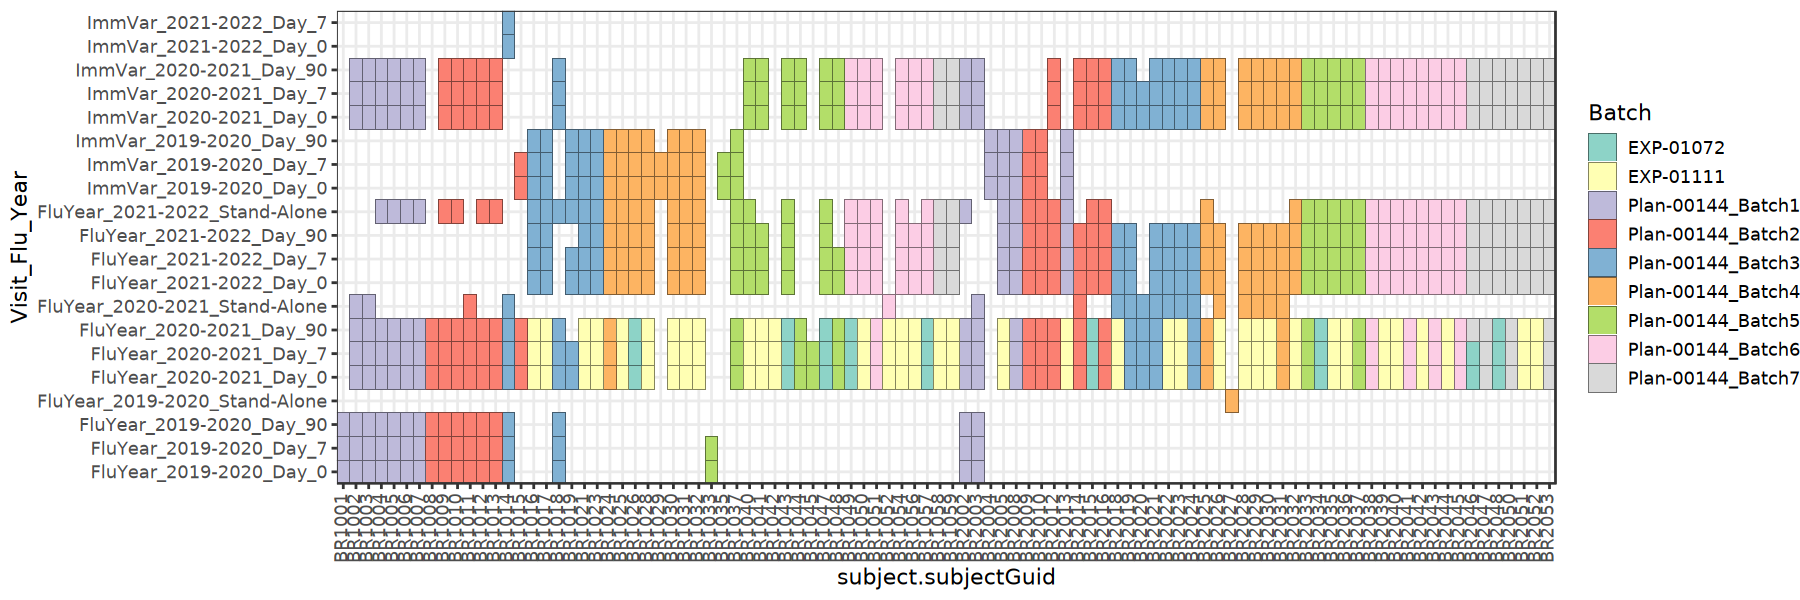

In [7]:
options(repr.plot.width = 15, repr.plot.height =5)

ggplot() +
  geom_tile(
      data = meta_data_vis ,
      aes(x = subject.subjectGuid,
          y = Visit_Flu_Year,
          fill = Batch),
      color = "black"
  ) +
  scale_fill_brewer(palette = "Set3"
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  theme_bw(base_size=13) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

# Duplicated Samples

In [8]:
duplicate_rows <- df[duplicated(df[, c("Sample.Kit.ID", "Assay")]) | duplicated(df[, c("Sample.Kit.ID", "Assay")], fromLast = TRUE), ] %>% filter(Sample!="BLANK") %>% arrange(Sample,Assay)

In [9]:
duplicate_rows<-duplicate_rows[grepl("KT",duplicate_rows$Sample.Kit.ID	),]

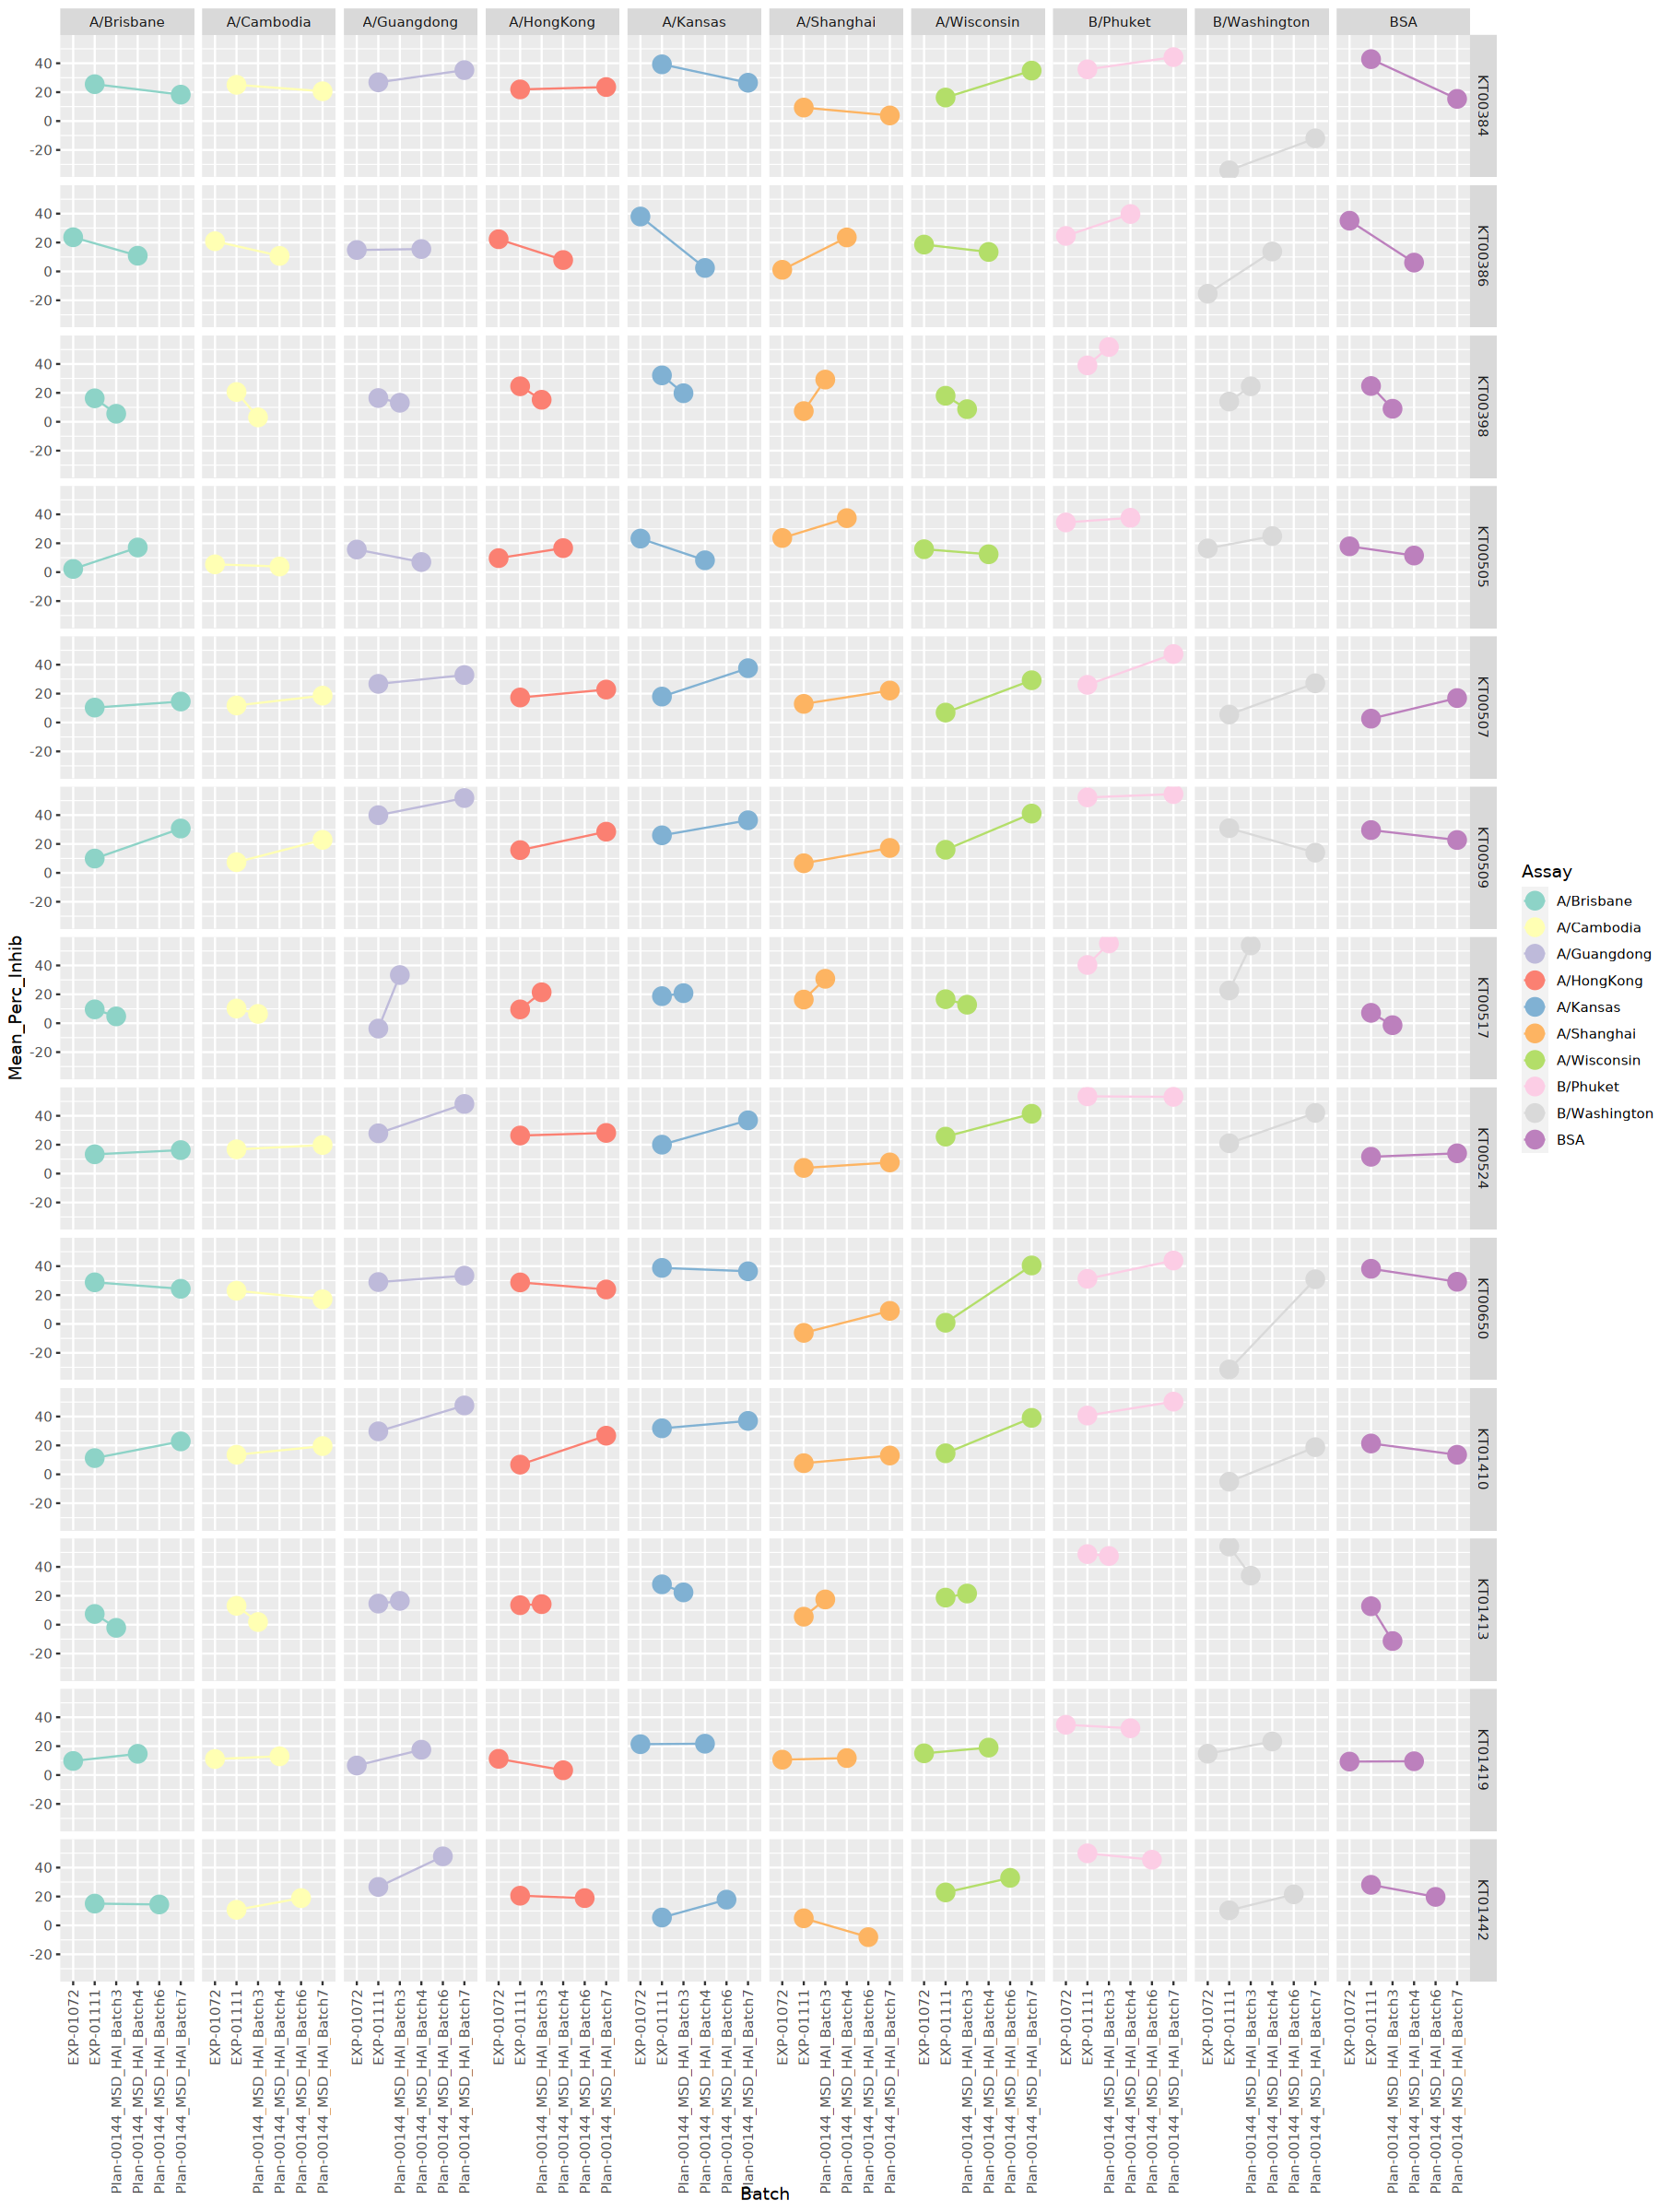

In [10]:
options(repr.plot.width = 15, repr.plot.height =20)

ggplot(duplicate_rows, aes(x = Batch, y = Mean_Perc_Inhib,  color = Assay)) +
  geom_point(size = 5) +
  geom_line(aes(group =  Sample.Kit.ID	)) +
  facet_grid(Sample.Kit.ID~ Assay)+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
  scale_color_brewer(palette = "Set3"
  )

In [11]:
delta_data <- duplicate_rows %>%
  group_by(Sample.Kit.ID, Assay) %>%
  arrange(Batch) %>%
  mutate(Delta = Mean_Perc_Inhib - lag(Mean_Perc_Inhib)) %>%
  filter(!is.na(Delta))

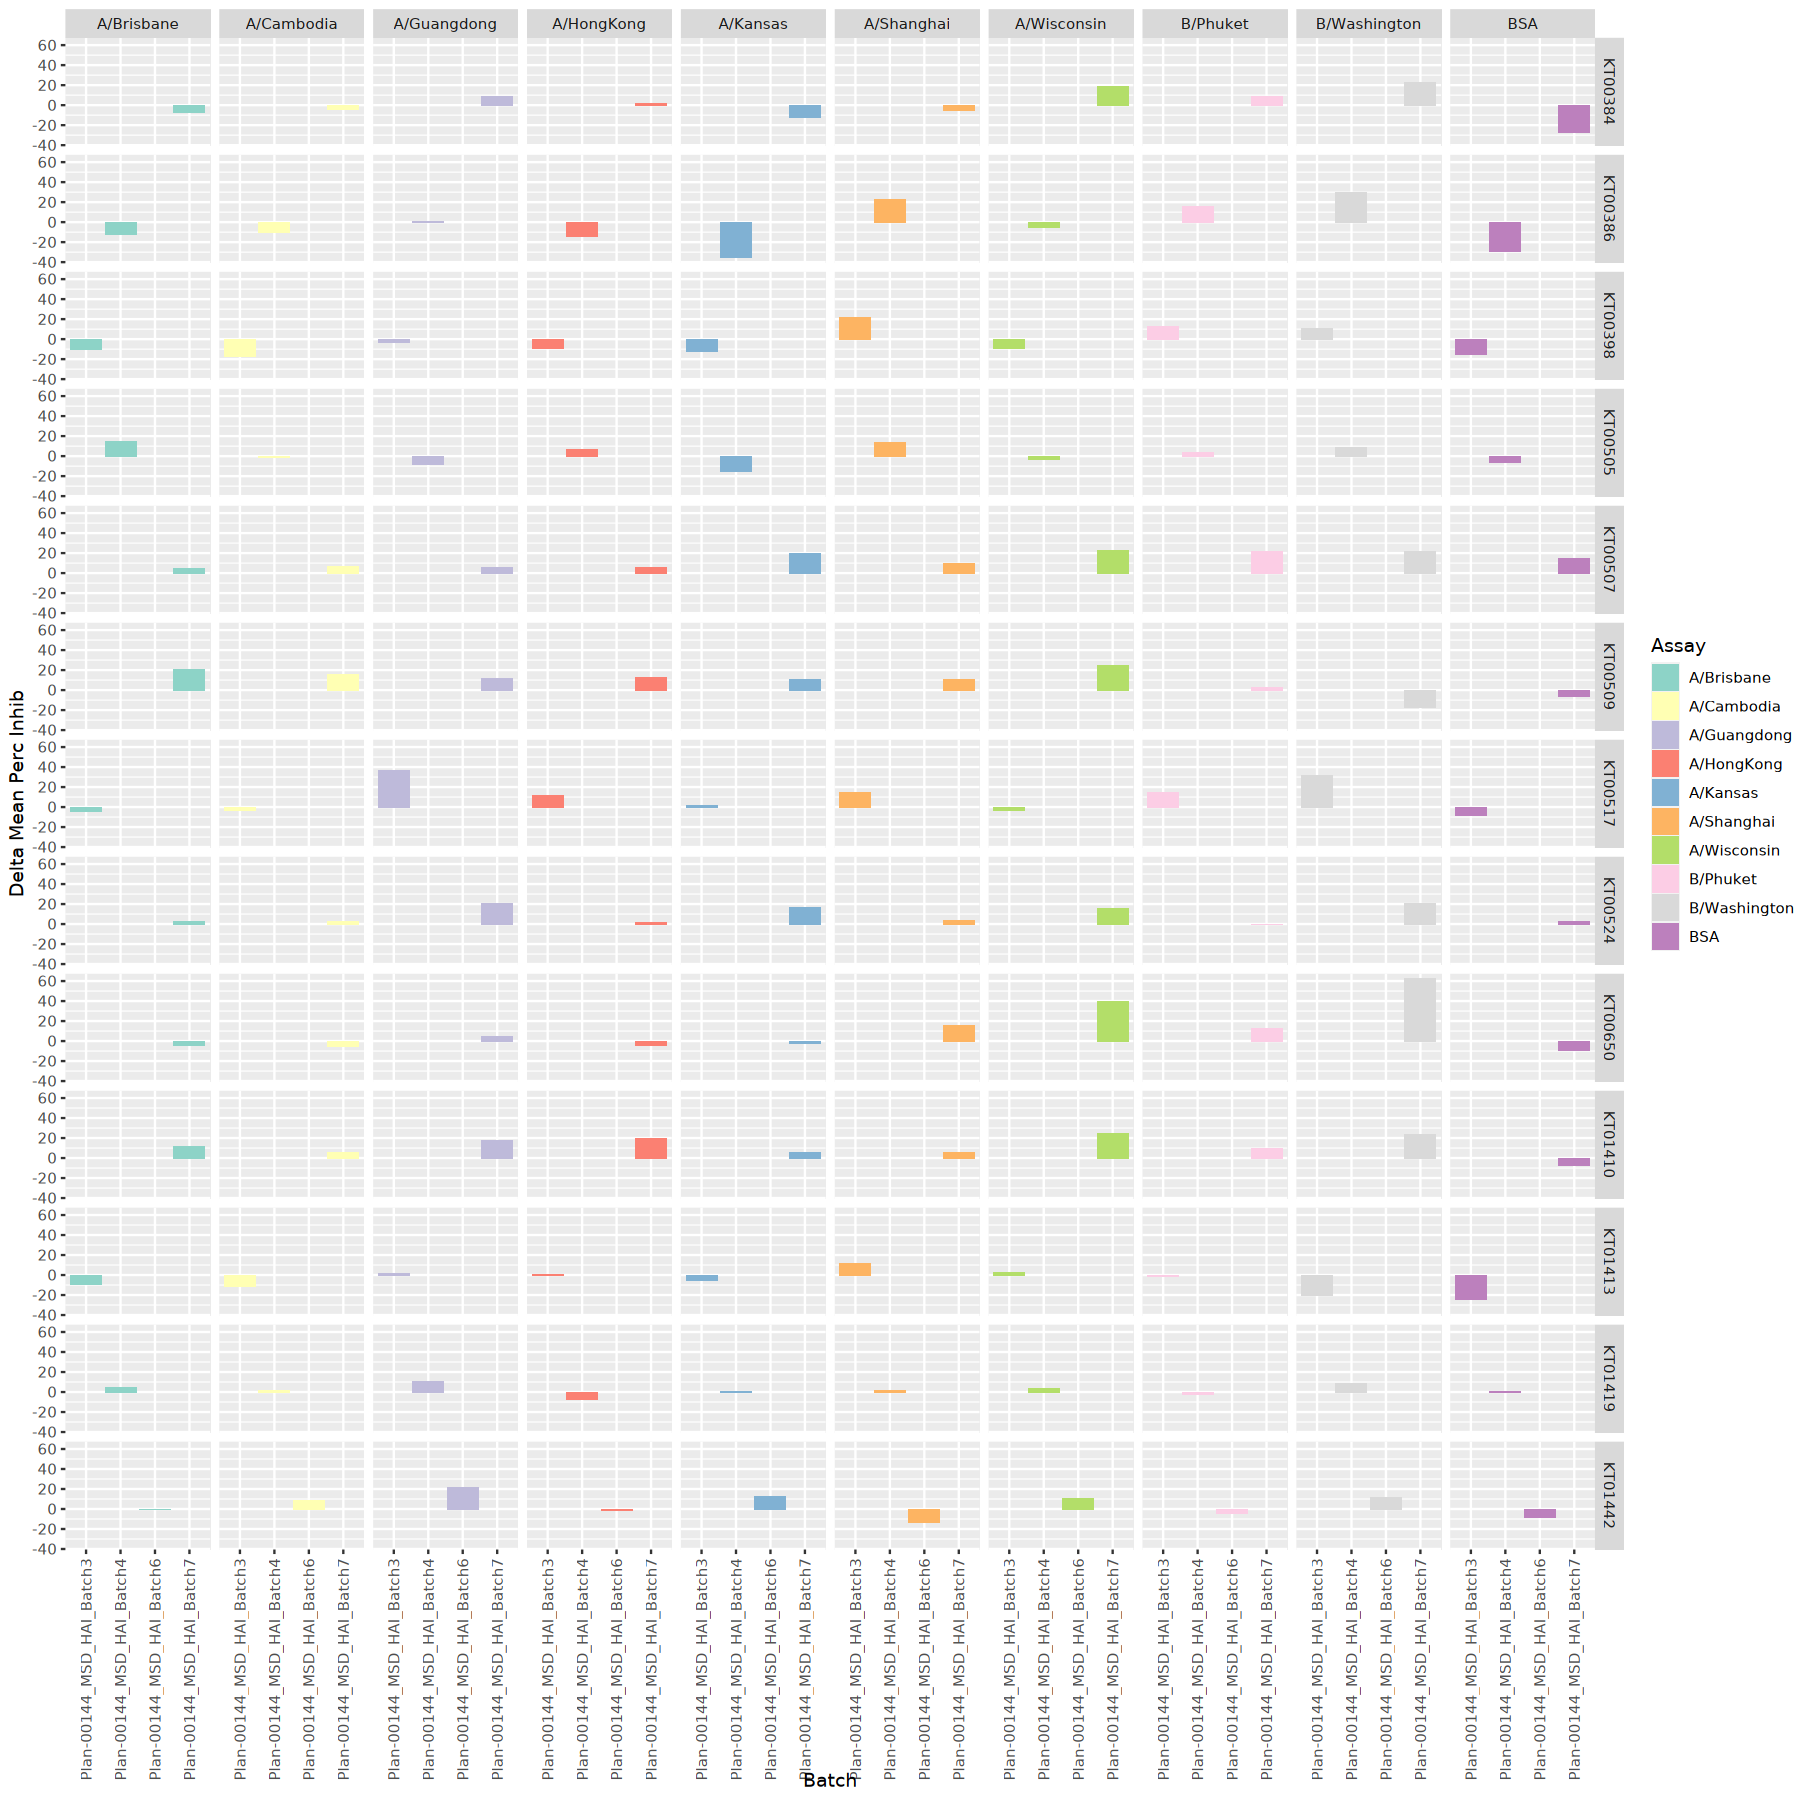

In [12]:
options(repr.plot.width = 15, repr.plot.height =15)

ggplot(delta_data, aes(x = Batch, y = Delta, fill = Assay)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_grid(Sample.Kit.ID ~ Assay) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  labs(y = "Delta Mean Perc Inhib")+
  scale_fill_brewer(palette = "Set3"
  )

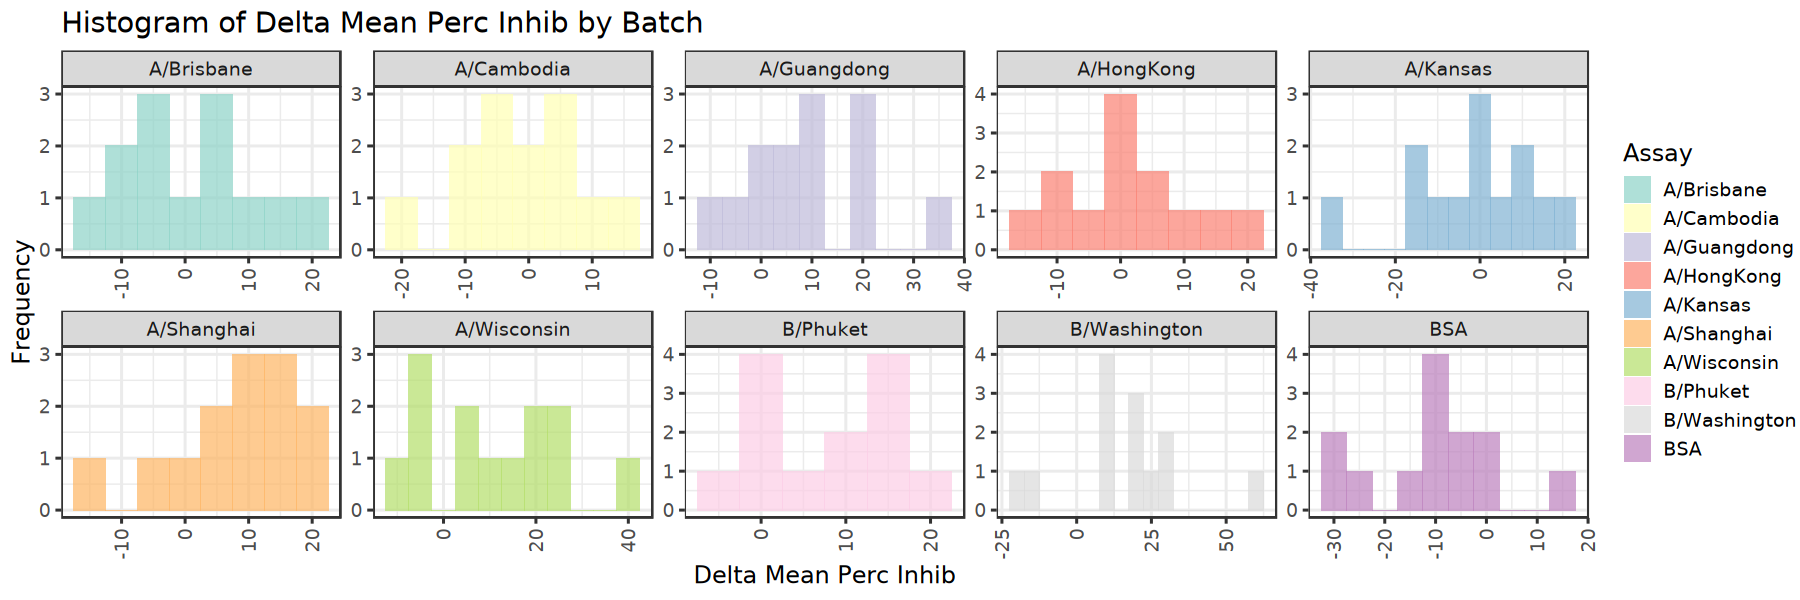

In [13]:
options(repr.plot.width = 15, repr.plot.height =5)

ggplot(delta_data, aes(x = Delta, fill = Assay)) +
  geom_histogram(binwidth = 5, alpha = 0.7, position = "dodge") +
  facet_wrap(~Assay, scales = "free",ncol=5) +theme_bw(base_size=14)+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  labs(x = "Delta Mean Perc Inhib", y = "Frequency", title = "Histogram of Delta Mean Perc Inhib by Batch")+
  scale_fill_brewer(palette = "Set3"
  )

# CV for all samples across batches

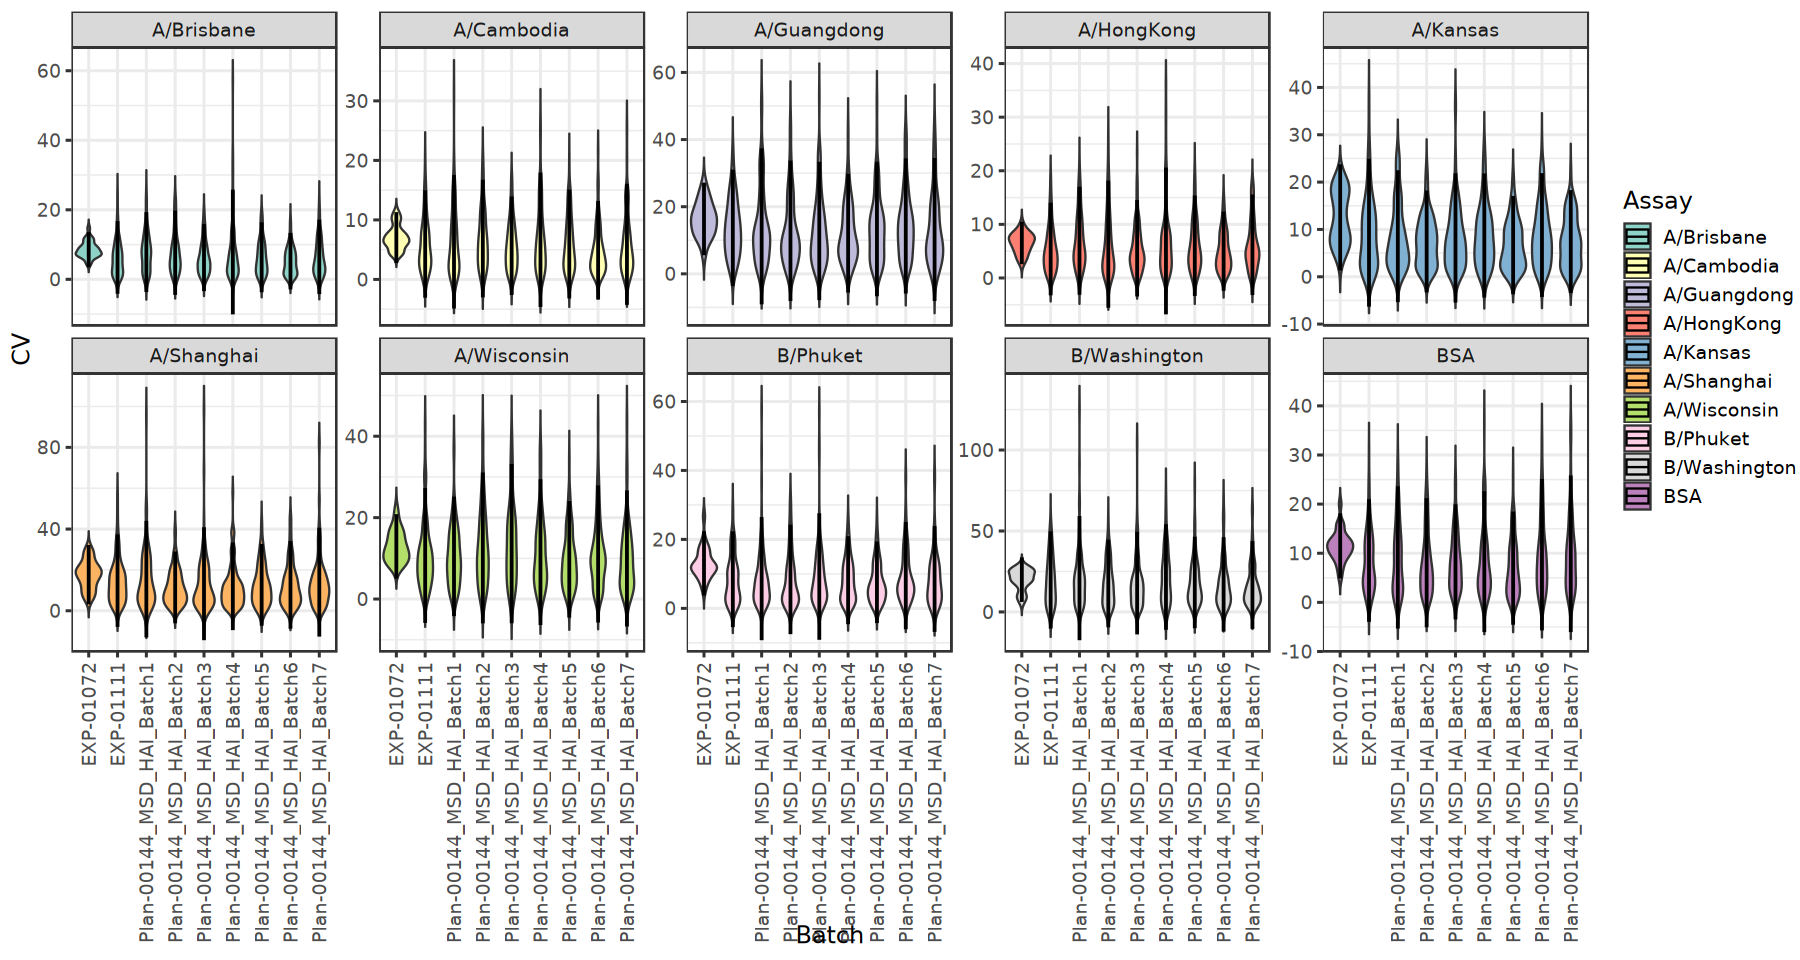

In [14]:
options(repr.plot.width = 15, repr.plot.height =8)


ggplot(df, aes(x = Batch, y=CV ,fill = Assay)) +
  facet_wrap(~Assay, scales = "free_y",ncol=5) +theme_bw(base_size=14)+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))+ geom_violin(trim=FALSE)+ stat_summary(fun.data="mean_sdl",  
                 geom="crossbar", width=0.05 )+
  scale_fill_brewer(palette = "Set3"
  )

# PCA

In [15]:

df_wide <- df %>% filter(grepl("KT",Sample.Kit.ID))%>%
  select(Assay, Sample, Mean_Perc_Inhib,Batch) %>%
  pivot_wider(names_from = Assay, values_from = Mean_Perc_Inhib)

In [16]:
pca_result <- prcomp(df_wide %>% select(-Sample,-Batch), scale. = TRUE)

# Extract PCA scores and bind with the Batch column
pca_scores <- as_tibble(pca_result$x) %>%
  mutate(Sample = df_wide$Sample)%>%
  mutate(Batch = df_wide$Batch)

In [17]:
pca_scores$sample.sampleKitGuid<-paste0("KT",substr(pca_scores$Sample,3,7))

In [18]:
pca_scores<-left_join(as.data.frame(pca_scores),meta_data,by="sample.sampleKitGuid")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


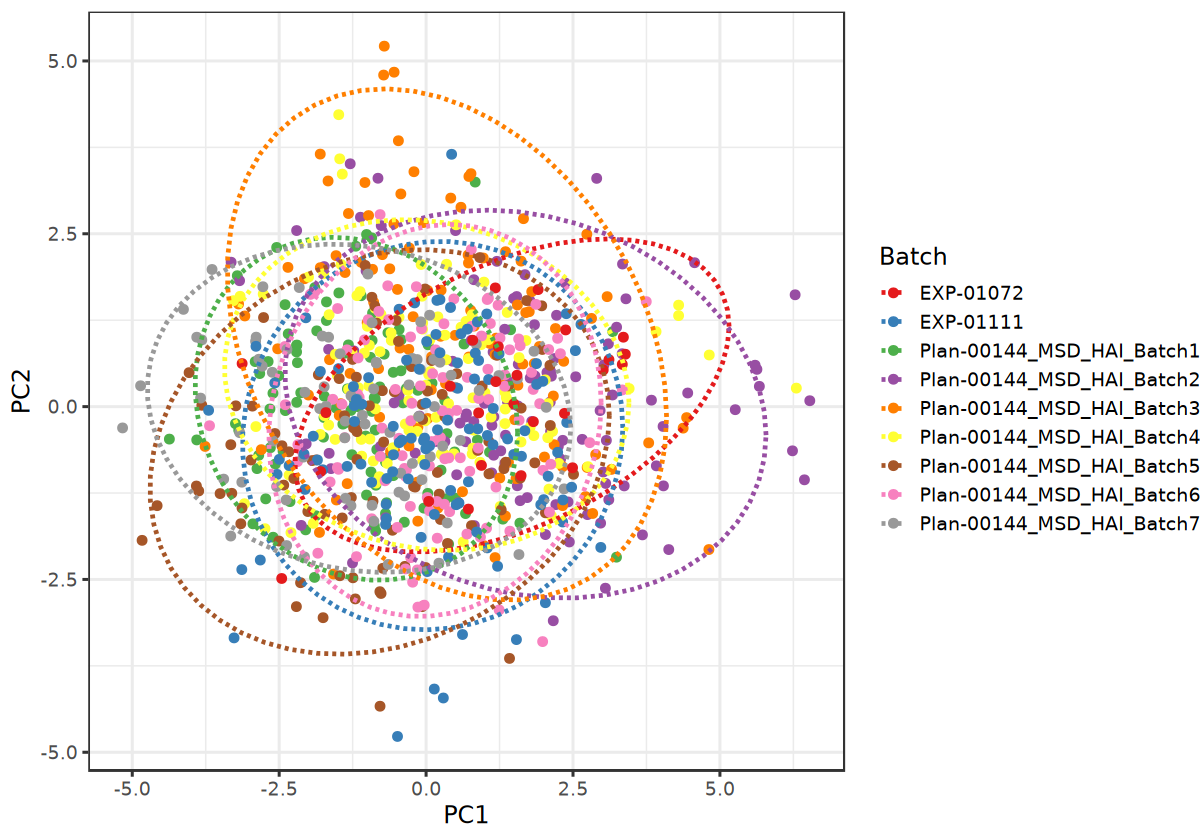

In [19]:
options(repr.plot.width = 10, repr.plot.height =7)
ggplot(pca_scores, aes(x = PC1, y = PC2, color = Batch)) +
  geom_point(size =2) +
  stat_ellipse(aes(group = Batch), linetype = "dashed", size = 1) +

  theme_minimal() +
  labs( x = "PC1", y = "PC2") +theme_bw(base_size=14)+
  scale_color_brewer(palette = "Set1"
  )

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Warning message:
“Removed 3 rows containing missing values (`geom_path()`).”


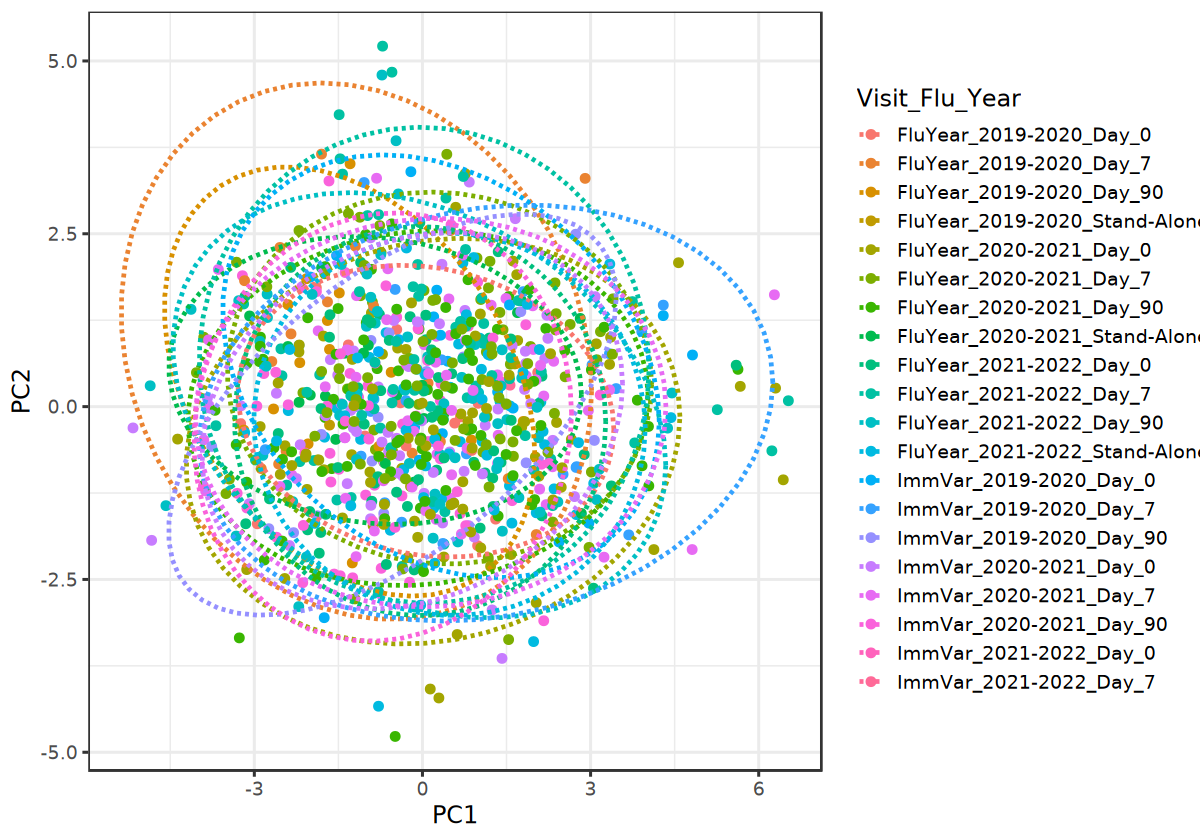

In [20]:
options(repr.plot.width = 10, repr.plot.height =7)
ggplot(pca_scores, aes(x = PC1, y = PC2, color = Visit_Flu_Year)) +
  geom_point(size =2) +
  stat_ellipse(aes(group = Visit_Flu_Year), linetype = "dashed", size = 1) +
  theme_minimal() +
  labs( x = "PC1", y = "PC2") +theme_bw(base_size=14)

# Final Assemble

In [21]:
df<-df %>% arrange(Batch)

In [22]:
df <- df[!duplicated((df[, c("Sample.Kit.ID", "Assay")] ), fromLast = TRUE), ] %>% filter(Sample!="BLANK") %>% arrange(Sample,Assay)

In [23]:
df<-df[grepl("KT",df$Sample.Kit.ID	),]
df$sample.sampleKitGuid<-df$Sample.Kit.ID

In [24]:
n_distinct(meta_data$sample.sampleKitGuid)

[1] 868

In [25]:
df<-left_join(df,meta_data,by="sample.sampleKitGuid") %>% select(-X.x)

In [26]:
table(df$Batch)


                EXP-01072                 EXP-01111 Plan-00144_MSD_HAI_Batch1 
                      230                       980                      1100 
Plan-00144_MSD_HAI_Batch2 Plan-00144_MSD_HAI_Batch3 Plan-00144_MSD_HAI_Batch4 
                     1180                      1150                      1130 
Plan-00144_MSD_HAI_Batch5 Plan-00144_MSD_HAI_Batch6 Plan-00144_MSD_HAI_Batch7 
                      980                      1140                       790 

In [27]:
write.csv(df,"HAI_Processed.csv")